# 03. Model Interpretability with SHAP
In this notebook, we use SHAP (SHapley Additive exPlanations) to explain the XGBoost model's predictions. This provides transparency into why certain loans are flagged as high risk.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [4]:
# Load data and prepare as in previous step
df = pd.read_csv('../data/final_modeling_data.csv')
categorical_cols = ['Employment.Type', 'State_ID', 'manufacturer_id', 'branch_id']
categorical_cols = [col for col in categorical_cols if col in df.columns]
target = 'loan_default'

df['Employment.Type'] = df['Employment.Type'].fillna('Unknown')
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Best params from 02_advanced_modeling
best_params = {'subsample': 0.7, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
scale_weight = float(np.sum(y_train == 0) / np.sum(y_train == 1))

model = XGBClassifier(**best_params, scale_pos_weight=scale_weight, random_state=42)
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

## 1. Global Interpretability
Summary plot shows the impact of each feature across the entire dataset.

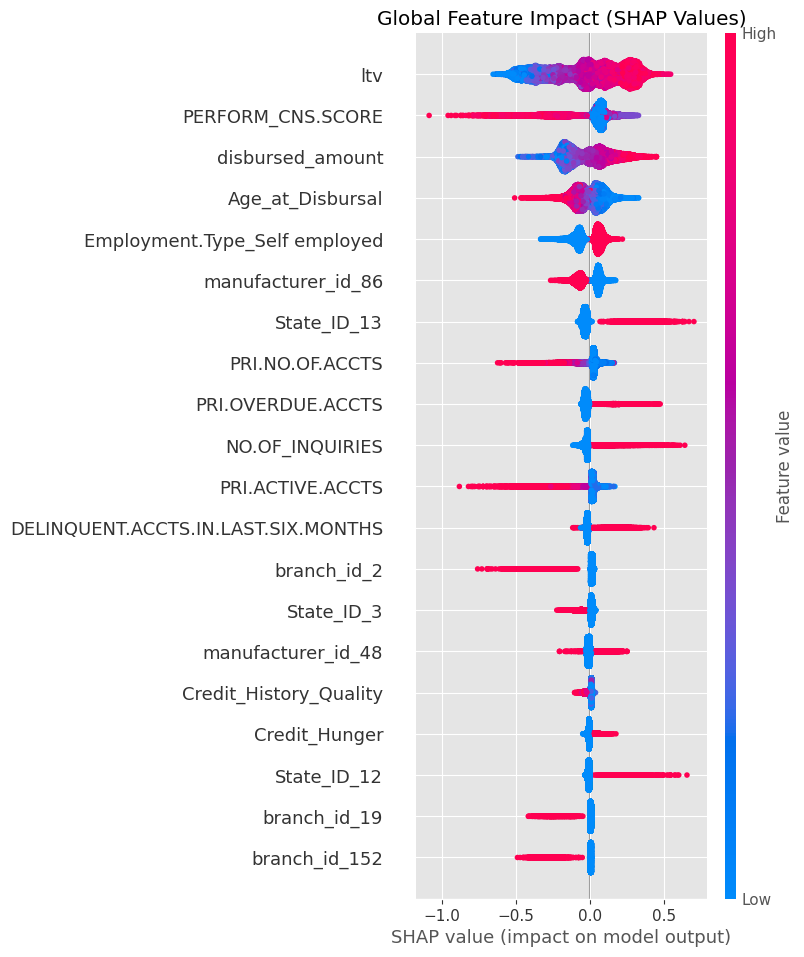

In [5]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, max_display=20, show=False)
plt.title('Global Feature Impact (SHAP Values)')
plt.show()

> [!NOTE]
> **Global SHAP Summary**: Features at the top have the most influence. Red points indicate high feature values, blue dots indicate low values. This shows if a feature increases or decreases risk.

## 2. Local Interpretability & Segment Analysis
Explaining specific segments like the 'Triple Threat'.

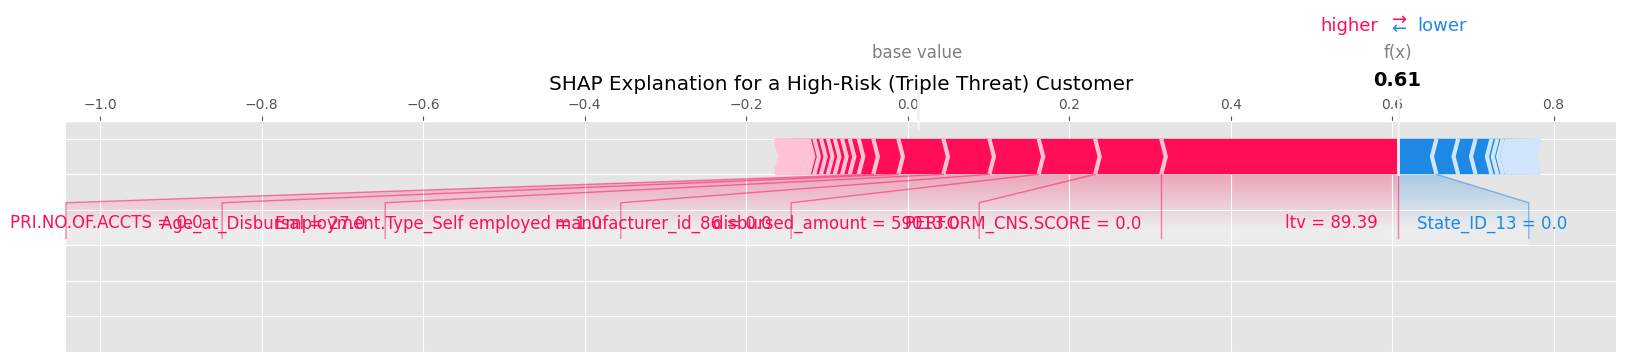

In [6]:
# Explain a high-risk instance (Triple Threat)
high_risk = X_test[X_test['Triple_Threat'] == 1].iloc[0]
shap_val_single = explainer.shap_values(high_risk.values.reshape(1, -1))

shap.force_plot(explainer.expected_value, shap_val_single[0], high_risk, matplotlib=True, show=False)
plt.title('SHAP Explanation for a High-Risk (Triple Threat) Customer')
plt.show()

> [!IMPORTANT]
> **Local Explanation (Force Plot)**: Shows exactly which features pushed this specific customer's risk score above or below the baseline. Essential for 'Explainable AI'.

## 3. Interaction Plot
Visualizing the interaction between LTV and Age, which we flagged in EDA.

## Confusion Matrix Analysis
Displaying TN, FP, FN, TP for a clearer view of classification errors.

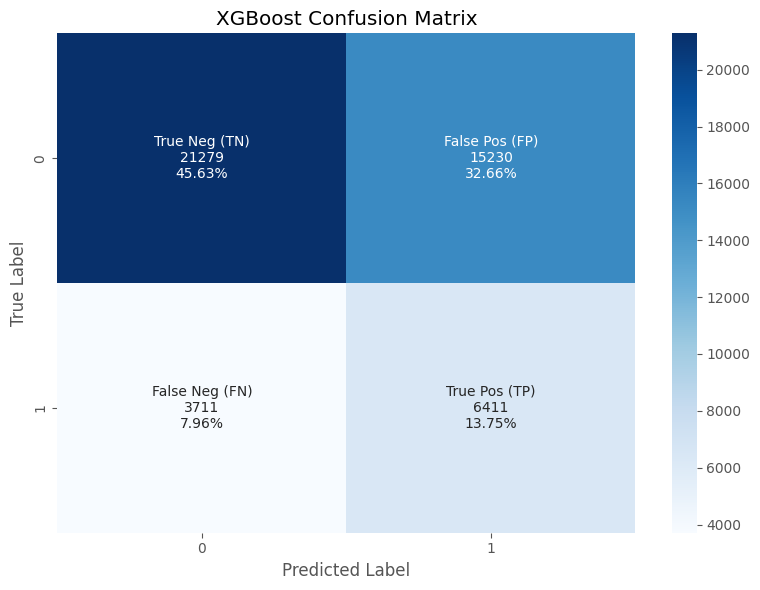

In [7]:
def plot_labeled_confusion_matrix(y_true, y_pred, title, ax):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg (TN)','False Pos (FP)','False Neg (FN)','True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig, ax = plt.subplots(figsize=(8, 6))
plot_labeled_confusion_matrix(y_test, model.predict(X_test), 'XGBoost Confusion Matrix', ax)
plt.tight_layout()
plt.show()

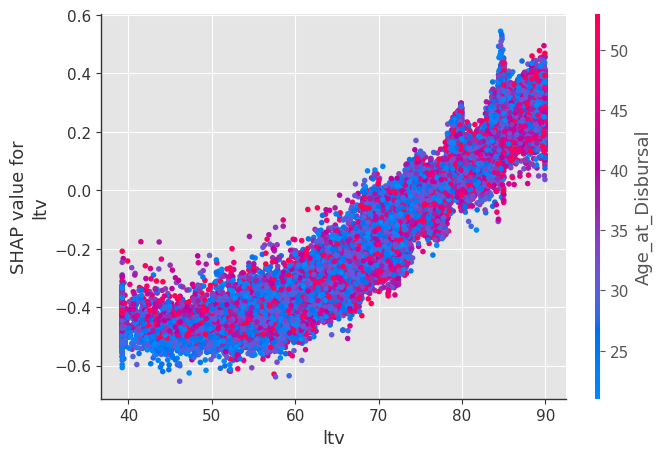

In [8]:
shap.dependence_plot('ltv', shap_values, X_test, interaction_index='Age_at_Disbursal')

> [!TIP]
> **Dependence Plot**: Reveals how the risk impact of one feature changes based on another feature (interaction). For example, high LTV might be riskier for younger borrowers.